# 数据清洗与查看

In [140]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
import os 
import ast

data_1 = pd.read_excel("./数据/train_data_new.xlsx")

data_4 = pd.read_csv("./附件/附件4：门店交易训练数据.txt",sep="\t",header=None)
column4 = {0:"车辆 id",1:"上架时间",2:"上架价格",3:"价格调整",4:"下架时间",5:"成交时间"}
data_4.rename(columns=column4,inplace=True)

Floder_Path = "./问题二/"
if not os.path.exists(Floder_Path):
    os.mkdir(Floder_Path)
Save_Path = Floder_Path + "data_4.xlsx"
data_4.to_excel(Save_Path,index=False)

data_merge = pd.merge(left=data_1,right=data_4,on="车辆 id")

data_merge = pd.merge(left=data_merge,right=data_4,how="outer")

PA_whether = {}
PA_price = {}
PA_time = {}
PA_num = {}
PA_num = {}
PA_freq = {}
for i in range(data_merge.shape[0]):
    PA = data_merge["价格调整"].values[i]
    PA = ast.literal_eval(PA)
    if not PA:
        PA_price[i] = data_merge["上架价格"].values[i]
        PA_time[i] = data_merge["上架时间"].values[i]
        PA_num[i] = 0
        PA_freq[i] = 0
        PA_whether[i] = False
    else:
        keys = []
        values = []
        for key,value in PA.items():
            keys.append(key)
            values.append(value)
        
        PA_price[i] = values[-1]
        PA_time[i] = keys[-1]
        PA_num[i] = len(keys)
        days = np.timedelta64(pd.to_datetime(PA_time[i])-pd.to_datetime(data_merge["上架时间"].values[i]),"D").astype(float)
        PA_freq[i] = PA_num[i]/days
        PA_whether[i] = True


PA_whether = pd.Series(PA_whether)
PA_freq = pd.Series(PA_freq)
PA_time = pd.Series(PA_time)
PA_price = pd.Series(PA_price)
PA_num = pd.Series(PA_num)

data_merge.insert(data_merge.shape[1]-1,"是否调价",PA_whether)
data_merge.insert(data_merge.shape[1]-1,"调价次数",PA_num)
data_merge.insert(data_merge.shape[1]-1,"调价频率",PA_freq)
data_merge.insert(data_merge.shape[1]-1,"最终调价时间",PA_time)
data_merge.insert(data_merge.shape[1]-1,"最终调价",PA_price)
data_merge.insert(data_merge.shape[1],"成交时间New",data_merge[data_merge["交易价格"].notnull()]["下架时间"])
data_merge["成交时间New"][-7:] = data_merge["成交时间"][-7:]
data_merge["成交周期"] = data_merge["成交时间New"].astype("datetime64")-data_merge["上架时间"].astype("datetime64")
data_merge["成交周期"] = data_merge["成交周期"].astype('timedelta64[D]').astype(int)



data_merge.dropna(subset=["年款"],inplace=True)

# 成交周期分箱
data_merge["成交速度"] = 1
data_merge["成交速度"][data_merge["成交周期"]<=7] = 1
data_merge["成交速度"][(data_merge["成交周期"]>7)&(data_merge["成交周期"]<=14)] = 2
data_merge["成交速度"][(data_merge["成交周期"]>14)&(data_merge["成交周期"]<=21)] = 3
data_merge["成交速度"][(data_merge["成交周期"]>21)&(data_merge["成交周期"]<=28)] = 4
data_merge["成交速度"][(data_merge["成交周期"]>28)&(data_merge["成交周期"]<=35)] = 5
data_merge["成交速度"][data_merge["成交周期"]>35] = 6
    
# 交易价格分箱
data_merge["车辆级别"] = 1
data_merge["车辆级别"][(data_merge["交易价格"]>20)&(data_merge["交易价格"]<=50)] = 2
data_merge["车辆级别"][(data_merge["交易价格"]>50)&(data_merge["交易价格"]<=100)] = 3
data_merge["车辆级别"][data_merge["交易价格"]>100] = 4

#降价比
data_merge["初始降价"] = data_merge["新车价"]-data_merge["上架价格"]
data_merge["最终降价"] = data_merge["新车价"]-data_merge["最终调价"].astype(float)
data_merge["初始降价比"] = (data_merge["新车价"]-data_merge["上架价格"])/data_merge["新车价"]
data_merge["最终降价比"] = (data_merge["新车价"]-data_merge["最终调价"].astype(float))/data_merge["新车价"]

mid = data_merge["成交周期"]
data_merge.drop(columns=["成交周期"],inplace=True)
data_merge.insert(data_merge.shape[1],"成交周期",mid)

mid = data_merge["成交速度"]
data_merge.drop(columns=["成交速度"],inplace=True)
data_merge.insert(data_merge.shape[1],"成交速度",mid)

In [141]:
Save_Path = Floder_Path + "data_merge.xlsx"
data_merge.to_excel(Save_Path,index=False)

# 数据分析

## 周期分布

In [124]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
import os 
import ast

data_merge = pd.read_excel("./问题二/data_merge.xlsx")

<AxesSubplot:xlabel='成交速度', ylabel='count'>

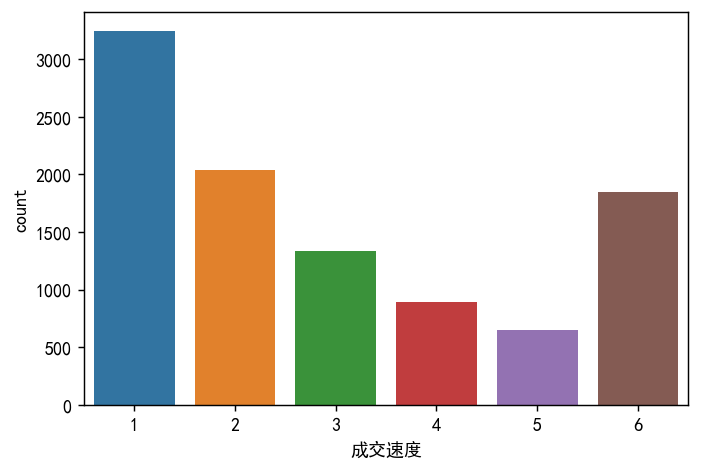

In [125]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.figure(dpi=130)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体  # 解决Seaborn中文显示问题
sns.countplot(x="成交速度",data=data_merge)

## 年款

In [129]:
data_merge = data_merge[data_merge["成交速度"]==6]

<AxesSubplot:xlabel='年款', ylabel='count'>

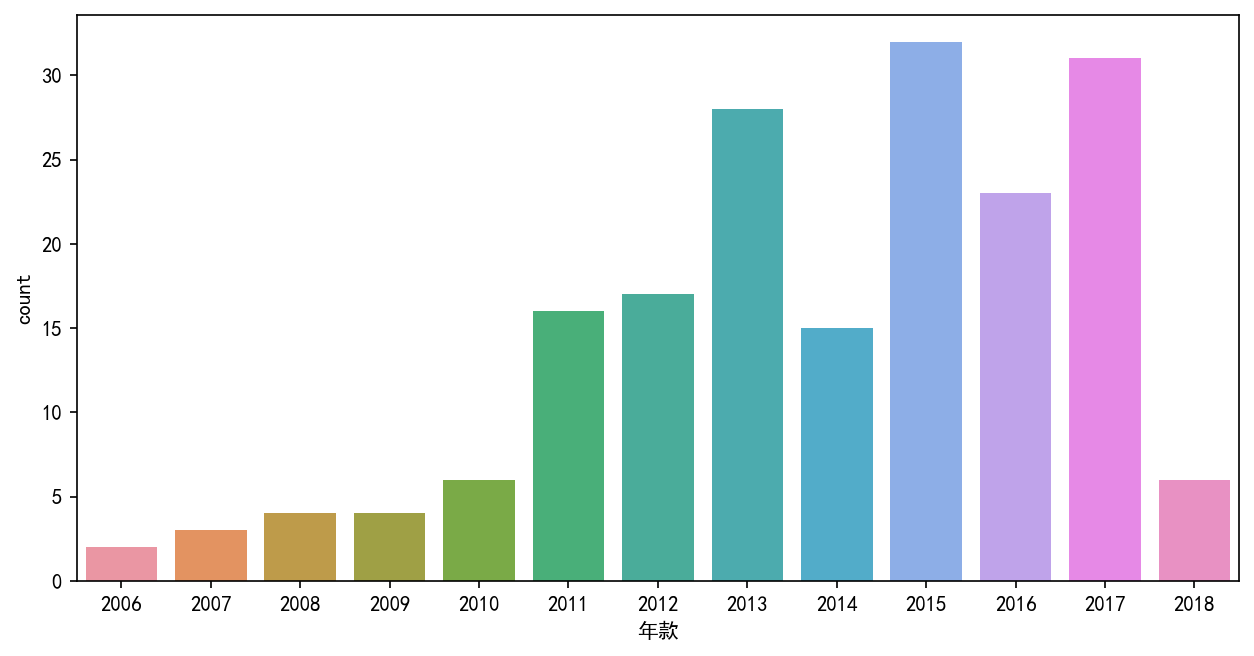

In [130]:
plt.figure(figsize=(10,5),dpi=150)
sns.countplot(x="年款",data=data_merge)

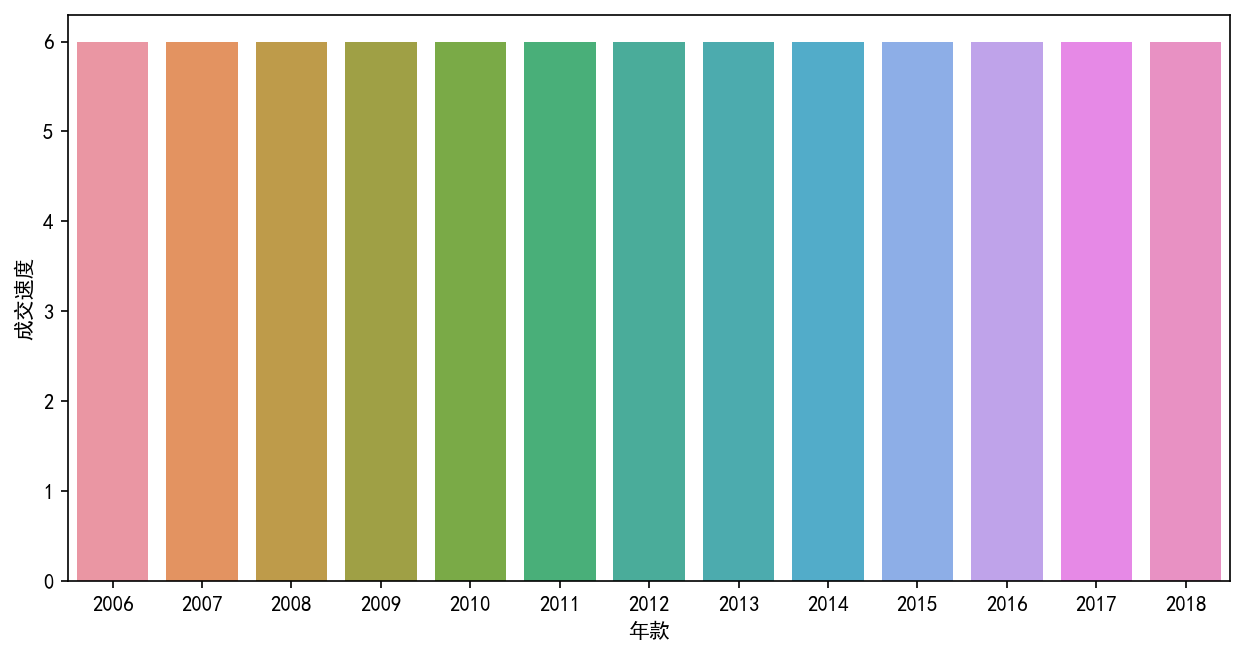

In [131]:
data_merge["年款"] = data_merge["年款"].astype("int32")

plt.figure(figsize=(10,5),dpi=150)
sns.barplot(x=data_merge["年款"],y=data_merge["成交速度"]
#             ,hue=data_merge["速度级别"]
           )
plt.show()

## 价格

<AxesSubplot:xlabel='最终调价', ylabel='count'>

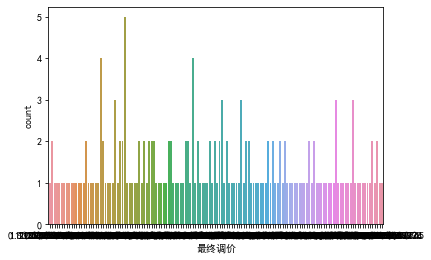

In [132]:
sns.countplot(x=data_merge["最终调价"],data=data_merge)

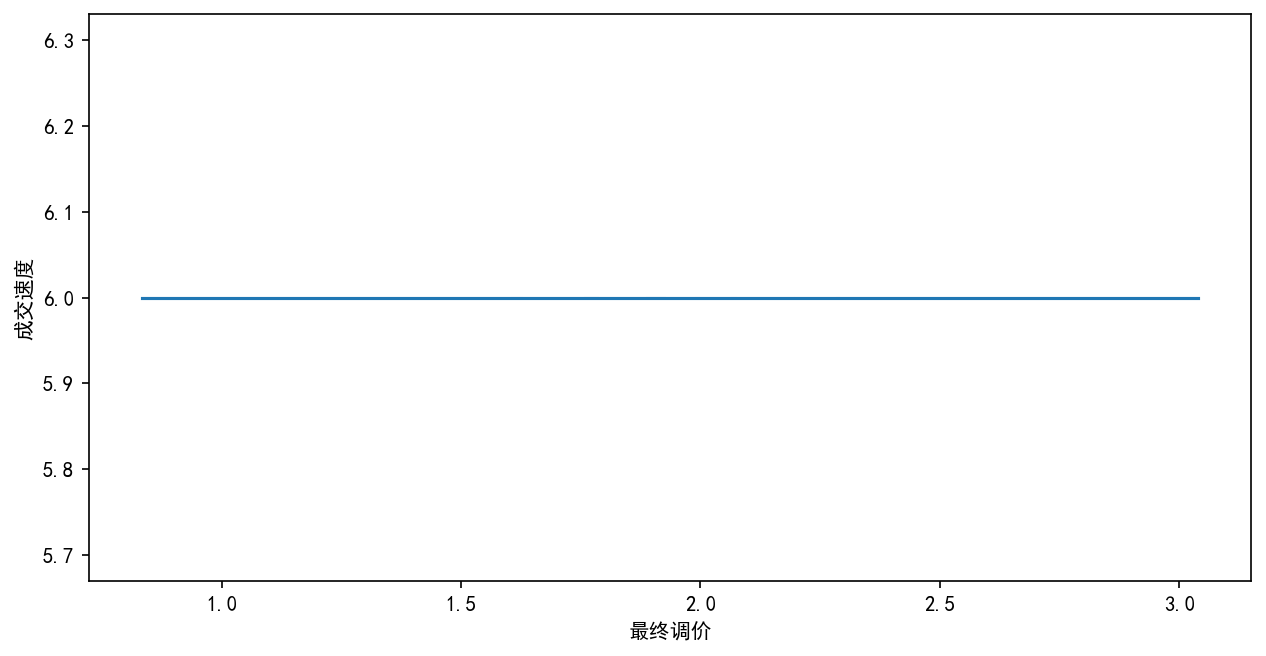

In [134]:
plt.figure(figsize=(10,5),dpi=150)
sns.lineplot(x=data_merge["最终调价"],y=data_merge["成交速度"]
#             ,hue=data_merge["速度级别"]
           )
plt.show()

## 相关性分析

In [135]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
import os 
import ast

data_merge = pd.read_excel("./问题二/data_merge.xlsx")
data_merge = data_merge[data_merge["成交速度"] == 6]

data_merge["展销时间"] = data_merge["展销时间"].values.astype("float64")
data_merge["注册日期"] = data_merge["注册日期"].values.astype("float64")
data_merge["上牌日期"] = data_merge["上牌日期"].values.astype("float64")

data_merge.corr('spearman').to_excel("./问题二/Corr.xlsx",index=True)

data_corr = pd.read_excel("./问题二/Corr.xlsx",index_col=0)

pd.DataFrame(np.abs(data_corr.loc["成交周期",:]).sort_values(ascending = False)).to_clipboard()

# AB测试

Delete number is: 265
Now column number is: 9728
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 成交周期, dtype: float64
Description of data larger than the upper bound is:
count    265.000000
mean     138.932075
std       40.502468
min       95.000000
25%      107.000000
50%      125.000000
75%      161.000000
max      277.000000
Name: 成交周期, dtype: float64
Delete number is: 175
Now column number is: 9553
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 交易价格, dtype: float64
Description of data larger than the upper bound is:
count    175.000000
mean      81.279486
std       55.113429
min       53.500000
25%       58.800000
50%       68.000000
75%       81.800000
max      658.000000
Name: 交易价格, dtype: float64
Delete number is: 18
Now column number is: 9535
Description of

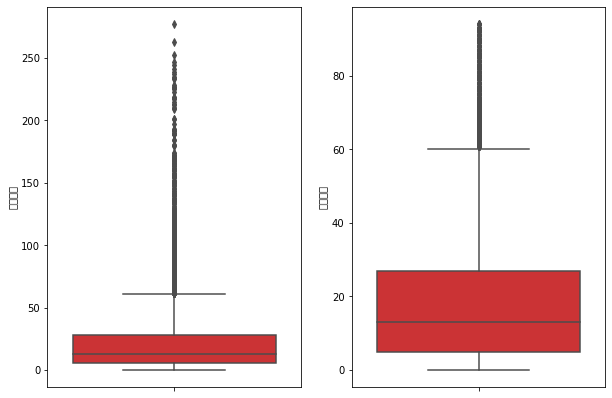

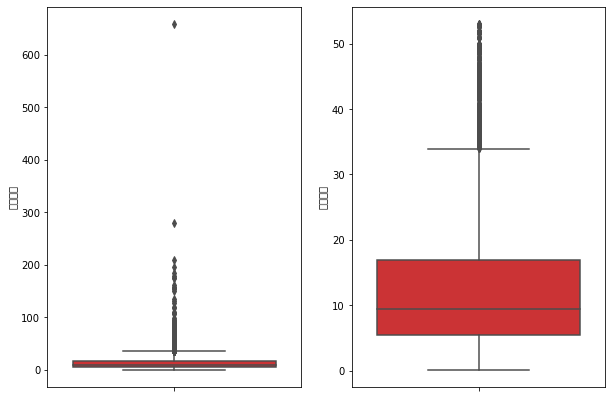

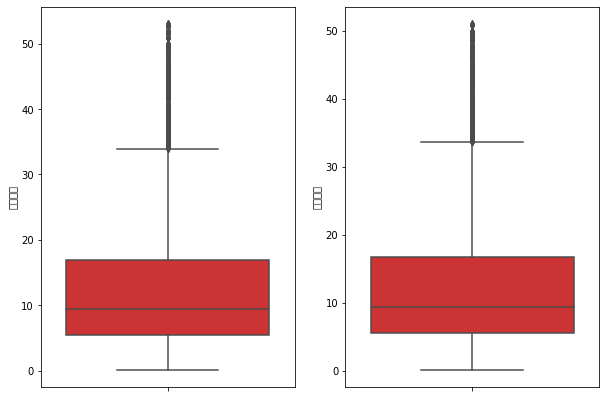

In [1]:
from Box_Figure import outliers_proc  #箱型图
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
import os 
import ast

data_merge = pd.read_excel("./问题二/data_merge.xlsx")

data_merge.drop(columns="成交时间",inplace=True)

data_merge.drop(columns=["成交时间New","下架时间"],inplace=True)

for column in ["成交周期","交易价格","最终调价"]:
# column = "成交周期"
    data_merge = outliers_proc(data_merge,column,scale=3)

data_merge["展销时间"] = data_merge["展销时间"].values.astype("float64")
data_merge["注册日期"] = data_merge["注册日期"].values.astype("float64")
data_merge["上牌日期"] = data_merge["上牌日期"].values.astype("float64")

data_1 = data_merge[data_merge["成交速度"] == 1 ]
data_2 = data_merge[data_merge["成交速度"] == 2 ]
data_3 = data_merge[data_merge["成交速度"] == 3 ]
data_4 = data_merge[data_merge["成交速度"] == 4 ]
data_5 = data_merge[data_merge["成交速度"] == 5 ]
data_6 = data_merge[data_merge["成交速度"] == 6 ]

from scipy import stats

ab_test = {}
for column in data_merge.columns:
    if data_merge[column].dtype == 'int64' or data_merge[column].dtype == 'float64':
        f,p = stats.f_oneway(data_1[column],data_2[column],data_3[column],data_4[column])
        ab_test[column] = p 
#         print(column+":",stats.f_oneway(data_1[column]
#                                         ,data_2[column]
#                                         ,data_3[column]
#                                         ,data_4[column]
#                                         ,data_5[column]
#                                         ,data_6[column]
#                                        ))

a = pd.Series(ab_test)
a = a[a>=0.05]

print(len(a.index))
print(a.index)

for data in [data_1,data_2,data_3,data_4,data_5,data_6]:
    data.drop(columns=a.index,inplace=True)

# 组合训练数据
data = pd.concat([data_1,data_2,data_3,data_4,data_5])

data=data_1

from sklearn import preprocessing # guiyihua
from sklearn.model_selection import train_test_split#划分训练集
from sklearn import metrics  
import scipy 
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
# data = data_merge
# data["展销时间"] = data["展销时间"].astype("object")
# data["注册日期"] = data["注册日期"].astype("object")
# data["上牌日期"] = data["上牌日期"].astype("object")

X = data.iloc[:,:-2]
X.drop(columns=['交易价格','最终调价', '车辆级别', '初始降价比', '最终降价比','上架价格', '价格调整'],inplace=True)

# X = encoder.fit_transform(X)

# # X = preprocessing.MinMaxScaler().fit_transform(X)
# # y = data.iloc[:,-2]

# model_1 = XGBRegressor()
# model = model_1
# selector = RFE(model).fit(X, y)
# selector.support_.sum()
# selector.ranking_
# X_wrapper = selector.transform(X)

# column3 = pd.DataFrame([*zip(data.columns,selector.ranking_)]).sort_values(by=1)[:-5].iloc[:,0]
# data_choosen = data[column3.tolist()]

# FR = {}
# data_corr = data_choosen.corr('spearman').abs()
# for i in data_corr.index:
#     listj = []
#     for j in data_corr.columns:
#         if i != j:            
#             if data_corr.loc[i,j] >= 0.8:
#                 listj.append(j)
#     FR[i] = listj

# data_choosen.drop(columns=["匿名特征5","初始降价比","新车价","调价次数","年款","初始降价","交易价格"],inplace=True)

# X = data_choosen
X = encoder.fit_transform(X)
X = preprocessing.MinMaxScaler().fit_transform(X)

y = np.log1p(data["交易价格"])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.9,random_state=100)

X.shape

# X = encoder.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)


# 模型初始化

model_1 = XGBRegressor()
model_2 = XGBRFRegressor()
model_3 = RandomForestRegressor()

print("***XGBoost***")
model_1 = model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
print("训练集R2:",model_1.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
print("测试集MSE:",metrics.mean_absolute_error(y_test,y_pred))

model_1 = model_1.fit(X,y)
X = data_6.iloc[:,:-2]
X.drop(columns=['交易价格','最终调价', '车辆级别', '初始降价比', '最终降价比','上架价格', '价格调整'],inplace=True)
X = encoder.fit_transform(X)
y = np.log1p(data_6["交易价格"])
y_pred = model_1.predict(X)

plt.figure()
plt.plot(range(len(y_pred[1:130])),y_pred[1:130],'b',label="price_predict")
plt.plot(range(len(y_pred[1:130])),y[1:130],'r',label="price_test")
plt.legend(loc="upper right")
plt.show()

In [10]:
print("***XGBRFoost***")

model_2 = model_2.fit(X_train,y_train)
y_pred = model_2.predict(X_test)
print("训练集R2:",model_2.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
print("测试集MSE:",metrics.mean_absolute_error(y_test,y_pred))

***XGBRFoost***
训练集R2: 0.7524298514078518
测试集R2: 0.7175893618150203
测试集MSE: 0.28946786245711853


In [11]:
print("***RF***")

model_3 = model_3.fit(X_train,y_train)
y_pred = model_3.predict(X_test)
print("训练集R2:",model_3.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
printprint("测试集MSE:",metrics.mean_absolute_error(y_test,y_pred))

***RF***
训练集R2: 0.9866874427939766
测试集R2: 0.9077706300163029


NameError: name 'printprint' is not defined

## 模型融合

In [73]:
from sklearn import datasets

iris = datasets.load_wine()
X, y = iris.data, iris.target

In [74]:
X_train,X_test,y_train,y_test= model_selection.train_test_split(X,y,test_size=0.2,random_state=100)

In [75]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

In [76]:
clf1=clf1.fit(X_train,y_train)
clf1.score(X_test,y_test)

0.7777777777777778

In [77]:
clf2=clf2.fit(X_train,y_train)
clf2.score(X_test,y_test)

1.0

In [78]:
sclf.fit(X_train,y_train)
sclf.score(X_test,y_test)

1.0

In [79]:
print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.72 (+/- 0.05) [KNN]
Accuracy: 0.97 (+/- 0.01) [Random Forest]
Accuracy: 0.96 (+/- 0.01) [Naive Bayes]
Accuracy: 0.97 (+/- 0.01) [StackingClassifier]


## 调参过程

0.32656522815482814 61


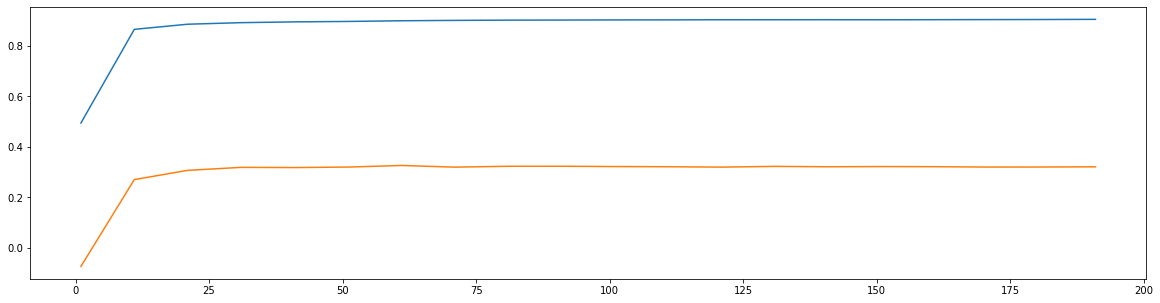

In [4]:
# n_estimators

train_score = []
val_score = []
for i in range(0,200,10):
    model = RandomForestRegressor(n_estimators=i+1
#                                   ,max_depth = 4
                                  ,n_jobs=-1,random_state = 100)
    model = model.fit(X_train,y_train)
    train_score.append(model.score(X_train,y_train))
    val_score.append(model.score(X_test,y_test))
print(max(val_score),(val_score.index(max(val_score))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),train_score)
plt.plot(range(1,201,10),val_score)
plt.show()

0.32656522815482814 61


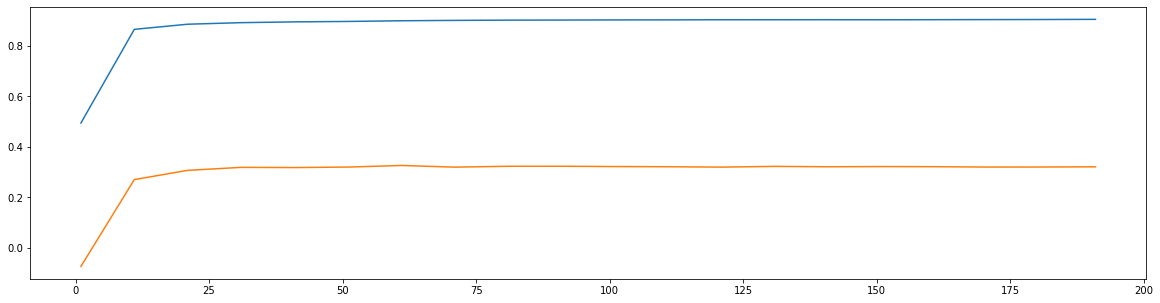

In [5]:
train_score = []
val_score = []
for i in range(0,200,10):
    model = RandomForestRegressor(n_estimators=i+1
                                  ,n_jobs=-1
#                                   ,max_depth = 4
                                  ,random_state = 100
                                 )
    model = model.fit(X_train,y_train)
    train_score.append(model.score(X_train,y_train))
    val_score.append(model.score(X_test,y_test))
print(max(val_score),(val_score.index(max(val_score))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),train_score)
plt.plot(range(1,201,10),val_score)
plt.show()

0.3268060636899428 57


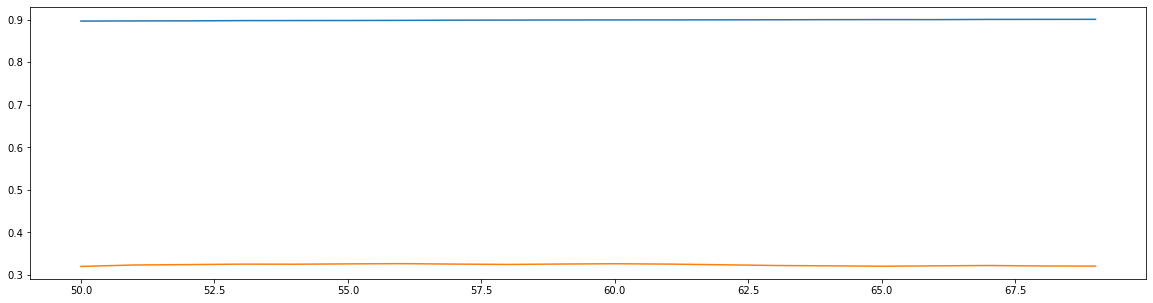

In [138]:
train_score = []
val_score = []
for i in range(50,70):
    model = RandomForestRegressor(n_estimators=i+1,n_jobs=-1,random_state = 100)
    model = model.fit(X_train,y_train)
    train_score.append(model.score(X_train,y_train))
    val_score.append(model.score(X_test,y_test))
print(max(val_score),(val_score.index(max(val_score)))+51)
plt.figure(figsize=[20,5])
plt.plot(range(50,70),train_score)
plt.plot(range(50,70),val_score)
plt.show()

In [149]:
model_1 = RandomForestRegressor(n_estimators=57,n_jobs=-1,random_state = 100) 
model_1 = model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
print("训练集R2:",model_1.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
print("MSE:",metrics.mean_squared_error(y_test,y_pred))

训练集R2: 0.8981710135295805
测试集R2: 0.3268060636899428
MSE: 506.6134073500277


0.05796567228903604 0


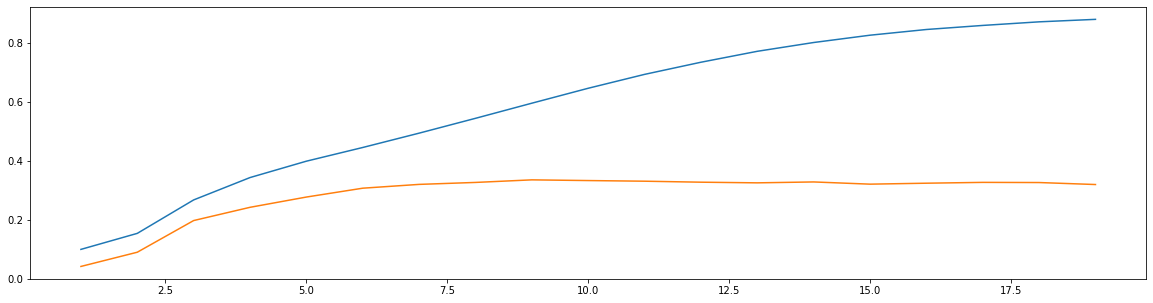

In [156]:
train_score = []
val_score = []
for i in range(1,20,1):
    model = RandomForestRegressor(n_estimators=57
                                  ,max_depth=i
                                  ,n_jobs=-1
                                  ,random_state = 100)
    model = model.fit(X_train,y_train)
    train_score.append(model.score(X_train,y_train))
    val_score.append(model.score(X_test,y_test))
diff_score = np.array(train_score) - np.array(val_score)
diff_score = diff_score.tolist()
print(min(diff_score),(diff_score.index(min(diff_score))))
plt.figure(figsize=[20,5])
plt.plot(range(1,20,1),train_score)
plt.plot(range(1,20,1),val_score)
plt.show()

In [150]:
model_1 = RandomForestRegressor(n_estimators=57,max_depth=8,n_jobs=-1,random_state = 100)
model_1 = model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
print("训练集R2:",model_1.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
print("MSE:",metrics.mean_squared_error(y_test,y_pred))

训练集R2: 0.5443692431816198
测试集R2: 0.3265654875623566
MSE: 506.79445338319846


0.08292675377245451 2


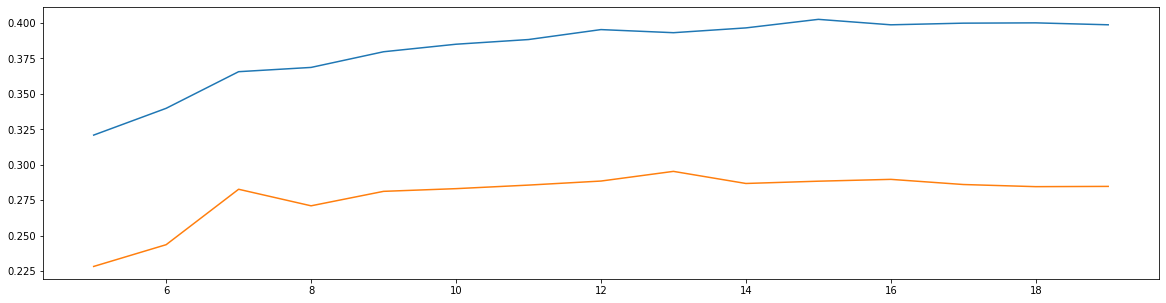

In [10]:
train_score = []
val_score = []
for i in range(5,20,1):
    model = RandomForestRegressor(n_estimators=57
                                  ,max_depth=5
                                  ,max_features =i 
                                  ,n_jobs=-1
                                  ,random_state = 100)
    model = model.fit(X_train,y_train)
    train_score.append(model.score(X_train,y_train))
    val_score.append(model.score(X_test,y_test))
diff_score = np.array(train_score) - np.array(val_score)
diff_score = diff_score.tolist()
print(min(diff_score),(diff_score.index(min(diff_score))))
plt.figure(figsize=[20,5])
plt.plot(range(5,20,1),train_score)
plt.plot(range(5,20,1),val_score)
plt.show()

In [141]:
#调整max_features
param_grid = {'max_features':np.arange(5,30,1)}
"""
max_features是唯一一个即能够将模型往左（低方差高偏差）推，也能够将模型往右（高方差低偏差）推的参数。我
们需要根据调参前，模型所在的位置（在泛化误差最低点的左边还是右边）来决定我们要将max_features往哪边调。
现在模型位于图像左侧，我们需要的是更高的复杂度，因此我们应该把max_features往更大的方向调整，可用的特征
越多，模型才会越复杂。max_features的默认最小值是sqrt(n_features)，因此我们使用这个值作为调参范围的
最小值。
"""
model = RandomForestRegressor(n_estimators=57,max_depth=8,n_jobs=-1,random_state = 100)
GS = GridSearchCV(model,param_grid,cv=10)
GS.fit(X,y)
print(GS.best_params_)
print(GS.best_score_)

{'max_features': 8}
0.32663555450635035


In [142]:
#调整min_samples_leaf
param_grid={'min_samples_leaf':np.arange(1, 1+50, 1)}
#对于min_samples_split和min_samples_leaf,一般是从他们的最小值开始向上增加10或20
#面对高维度高样本量数据，如果不放心，也可以直接+50，对于大型数据，可能需要200~300的范围
#如果调整的时候发现准确率无论如何都上不来，那可以放心大胆调一个很大的数据，大力限制模型的复杂度
model = RandomForestRegressor(n_estimators=57,max_depth=8,max_features=8,n_jobs=-1,random_state = 100)
GS = GridSearchCV(model,param_grid,cv=10)
GS.fit(X,y)
print(GS.best_params_)
print(GS.best_score_)

{'min_samples_leaf': 4}
0.32943055213446776


In [143]:
#调整min_samples_split
param_grid={'min_samples_split':np.arange(2, 2+20, 1)}
model = RandomForestRegressor(n_estimators=57,max_depth=8,max_features=8,min_samples_leaf=4,n_jobs=-1,random_state = 100)
GS = GridSearchCV(model,param_grid,cv=10)
GS.fit(X,y)
print(GS.best_params_)
print(GS.best_score_)

{'min_samples_split': 2}
0.32943055213446776


In [145]:
#调整Criterion
param_grid = {'criterion':['mse', 'mae']}
model = RandomForestRegressor(n_estimators=57,max_depth=8,max_features=8,min_samples_split=2,n_jobs=-1,random_state = 100)
GS = GridSearchCV(model,param_grid,cv=10)
GS.fit(X,y)
print(GS.best_params_)
print(GS.best_score_)

{'criterion': 'mse'}
0.3266355545063503


In [148]:
model_1 = model 
model_1 = model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
print("训练集R2:",model_1.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
print("MSE:",metrics.mean_squared_error(y_test,y_pred))

训练集R2: 0.9026619687898378
测试集R2: 0.32161651681279924
MSE: 510.51881095547776


In [99]:
y_pred

array([22.062996, 30.229385, 28.230724, ..., 21.240807, 12.271648,
       12.552915], dtype=float32)

### 线性回归

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
model_1 = LinearRegression()
model_1 = model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
print("训练集R2:",model_1.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
print("MSE:",metrics.mean_squared_error(y_test,y_pred))


训练集R2: 0.31908969482232774
测试集R2: 0.29520352467053323
MSE: 530.3959596131862


### 支持向量机回归

In [12]:
from sklearn.svm import SVR
from sklearn import metrics 
model_1 = SVR()
model_1 = model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
print("训练集R2:",model_1.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
print("MSE:",metrics.mean_squared_error(y_test,y_pred))

训练集R2: 0.07516553524161829
测试集R2: 0.07967415527701172
MSE: 692.5930061447585


### 随机森林

In [8]:
from sklearn.preprocessing import MinMaxScaler

X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

In [10]:
model_1 = RandomForestRegressor()
model_1 = model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
print("训练集R2:",model_1.score(X_train,y_train))
print("测试集R2:",metrics.r2_score(y_test,y_pred))
print("MSE:",metrics.mean_squared_error(y_test,y_pred))

训练集R2: 0.9051331460431213
测试集R2: 0.19391893149563633
MSE: 606.6178773886944
